# 네이버 영화 리뷰 데이터 10000개 수집 X 2 : 총 2만개

In [ ]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import time

In [ ]:
browser = webdriver.Chrome()
url = "https://movie.naver.com/movie/point/af/list.nhn"
browser.get(url)

In [ ]:
from tqdm import tqdm
reviewData = list()
# links = browser.find_element_by_class_name('paging').find_elements_by_tag_name('a')
_iter = 1000
for page in range(_iter):
    for row in browser.find_elements_by_tag_name('tr')[1:]:
        title = row.find_element_by_class_name('title').text.split('\n')[0]
        point = row.find_element_by_class_name('point').text
        text = row.find_element_by_class_name('title').text.split('\n')[1][:-3]
        reviewData.append((title, point, text))
    browser.find_element_by_class_name('pg_next').click()

In [ ]:
import csv

csvFile = open("./reviewData.csv", "a", newline="\n")
csvWriter = csv.writer(csvFile)

for row in reviewData:
    csvWriter.writerow(row)

csvFile.close()

# 목표 1. 긍정 리뷰와 부정 리뷰의 차이점 파악하기 (자주나온 단어, 형용사 등)
# 목표 2. 리뷰가 영화별(ex) 엑시트, 봉오동전투 등등)로 저절로 군집화 되는지!

# EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/NanumGothic.ttf").get_name()

rc('font',family=font_name)

# 데이터 불러오기
data = pd.read_csv('./reviewData.csv', encoding="cp949", header=None)
data.columns = ['title', 'score', 'review_content']
data.head()

,title,score,review_content
0,봉오동 전투,1,하지만 미국의 원폭으로 독립했지. 독립운동하다가 학살만 당함
1,판도라,1,우리 후손들 원전없는 세상에서 빚더미 안겨주자
2,인형의 집으로 오세요,10,사랑받고싶어하는 인간의 본능과 현실을 1990년대 미국 청소년 던이라는 왕따소녀를 ...
3,변신,1,진짜 어지간하면 그냥 좋게 쓰려고 했는데... 아무리 생각해도 둘째 딸을 지하실로 ...
4,그것: 두 번째 이야기,10,근데 왜 니가 나한테 왜 이렇게


In [2]:
data.info() # null값은 없는 것으로 확인된다.`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
title             20000 non-null object
score             20000 non-null int64
review_content    20000 non-null object
dtypes: int64(1), object(2)
memory usage: 468.8+ KB


# 평점 분포 보기

In [3]:
# 평점 카운트 하고 인덱스 기준으로 정렬하여 평점별 카운트 리스트 만들기
scores = list(data['score'].value_counts().sort_index()) 

Text(0.5, 1.0, '평점 별 리뷰 개수')

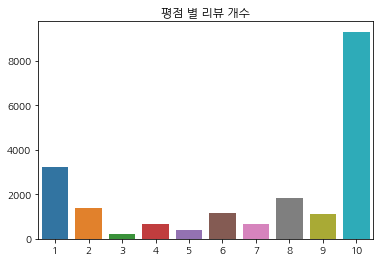

In [4]:
sns.barplot(list(range(1,11)), scores)
plt.title('평점 별 리뷰 개수')
# 양 극단에 많은 데이터가 포진되어 있는 것을 볼 수 있고
# 10점에 절반 가까이 되는 수가 표시됨을 볼 수 있다.
# 네티즌들이 후한점수를 주거나 댓글알바들이 있거나 등을 생각해 볼 수 있다.

## 4~6점은 긍정 부정이 애매한 데이터라 제외하고 1 ~ 4 점은 부정 7 ~ 10은 긍정데이터라고 보고 진행한다

12909 5508


<BarContainer object of 2 artists>

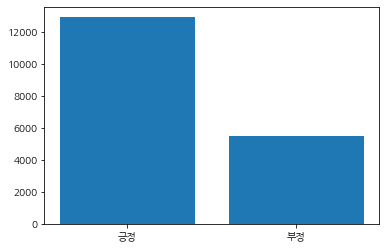

In [5]:
N_review = data[data['score'] < 5]
P_review = data[data['score'] > 6]

print(len(P_review), len(N_review))
plt.bar(['긍정', '부정'], (len(P_review), len(N_review)))
# 최근에 재밌는 영화가 있었나보다. 긍정적인 데이터가 더 많음을 볼 수 있다.

# 1. 품사 별로 분포 파악하기
### 일단은 전처리를 하지 않았다.
### 이유는 조사나 형용사나 문장부호도 하나의 기준이 될 수 있기 때문에 일단은 전부다 파악해 보기로 했다.

In [6]:
from collections import Counter, defaultdict
from konlpy.tag import Okt
# komoran이 제일 정확도나 품질이 좋긴 하지만, 네티즌 데이터를 분석하는 것이므로 twitter를 써서 해보겠다!
okt = Okt()

# 각 단어별 품사 카운트 

In [7]:
okt.tagset # 어떤 품사가 있는지 살펴보기

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [8]:
negVoca = defaultdict(Counter) # key : 형태소 value : dict()의 key: 단어 : 카운트
posVoca = defaultdict(Counter) # ex) 명사 - (바보 - (7))

# 리뷰데이터 (token, 품사) 별로 카운팅 하기
for review in N_review['review_content']:
    morphemes = okt.pos(review) # review 형태소 분석하기
    for (token, pos) in morphemes:
        negVoca[pos][token] += 1

for review in P_review['review_content']:
    morphemes = okt.pos(review) # review 형태소 분석하기
    for (token, pos) in morphemes:
        posVoca[pos][token] += 1

In [9]:
print(posVoca['Josa']) # 긍정리뷰 조사 카운트 보기

Counter({'이': 3686, '에': 2572, '의': 2295, '가': 2128, '을': 1884, '도': 1703, '는': 1555, '은': 1362, '를': 1265, '으로': 755, '과': 713, '에서': 613, '만': 577, '로': 576, '한': 489, '인': 483, '요': 466, '보다': 436, '고': 431, '와': 383, '하고': 381, '다': 306, '까지': 299, '게': 289, '이다': 267, '랑': 198, '인데': 170, '이랑': 170, '이고': 166, '나': 162, '면': 160, '라': 151, '서': 146, '엔': 139, '에게': 137, '지': 133, '이라': 133, '부터': 127, '아': 124, '라고': 119, '에는': 101, '이나': 96, '지만': 94, '에요': 94, '라는': 94, '보다는': 90, '보단': 87, '이네': 83, '네': 79, '든': 76, '마다': 75, '이지만': 73, '처럼': 72, '야': 68, '인가': 67, '에도': 64, '이라는': 56, '니까': 54, '인지': 54, '밖에': 54, '이에요': 52, '한테': 51, '니': 49, '에서는': 45, '이라고': 45, '으로는': 38, '말고': 36, '이야': 36, '께': 36, '냥': 36, '만큼': 35, '으론': 34, '에서도': 33, '이지': 33, '만으로도': 32, '여': 31, '치고': 31, '이란': 31, '여서': 30, '예요': 30, '에겐': 29, '에선': 29, '만큼은': 27, '냐': 27, '라서': 26, '로는': 26, '스럽게': 26, '에게는': 26, '난': 26, '이며': 25, '만은': 25, '같이': 24, '라도': 23, '인거': 22, '대로': 21, '으로서': 21, '으로

# 품사별 그래프 그리기

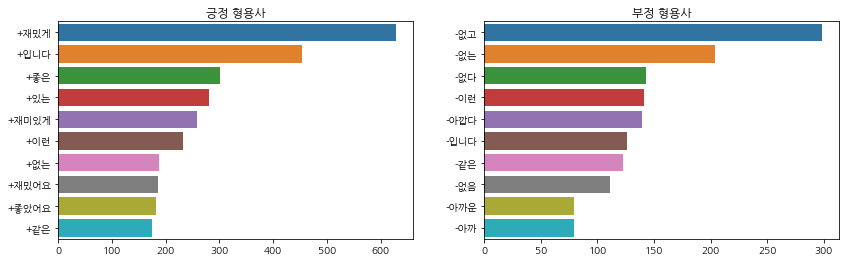

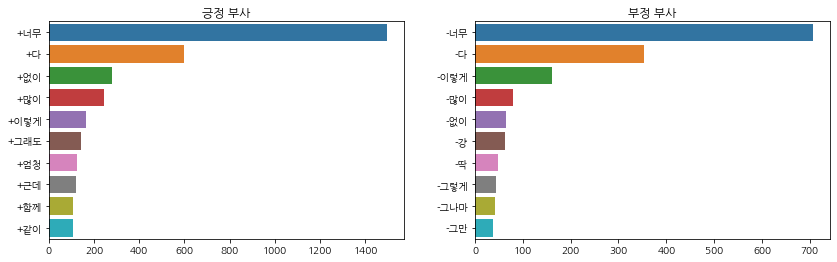

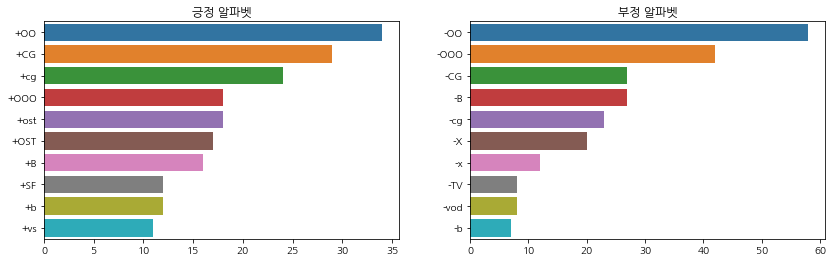

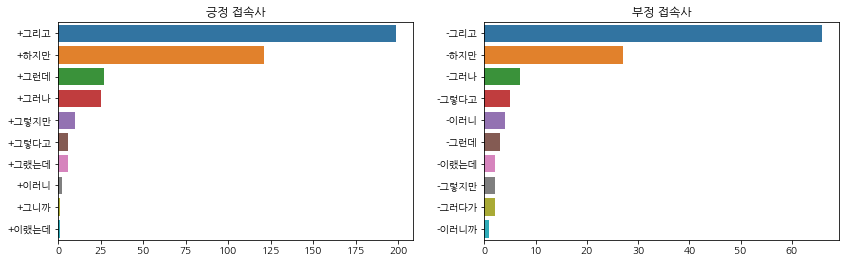

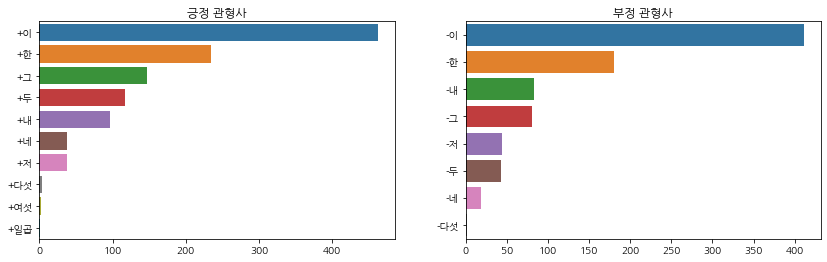

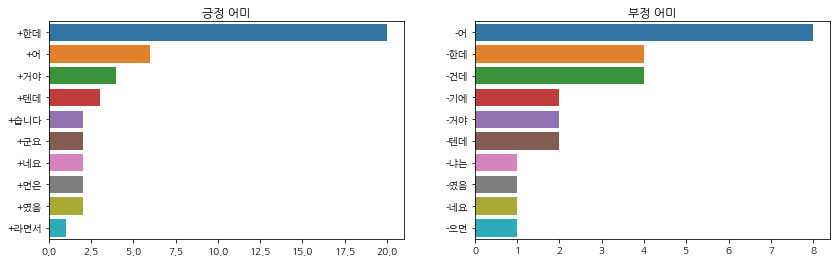

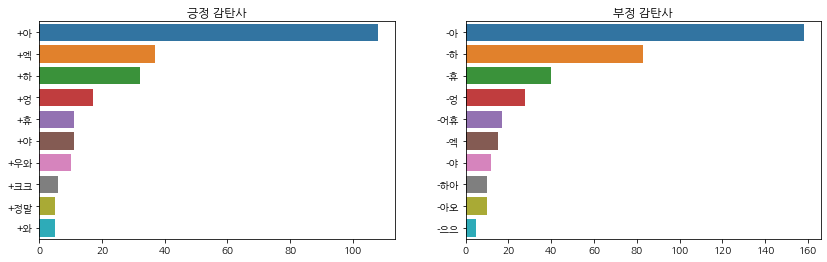

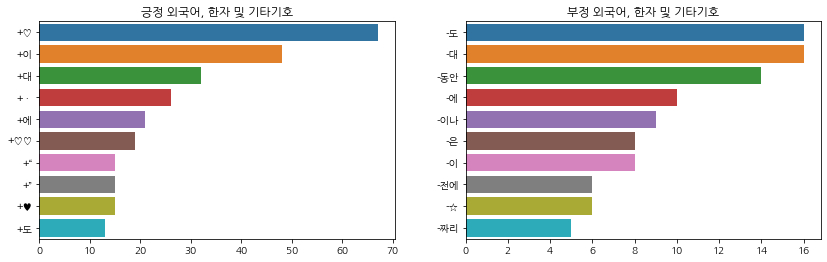

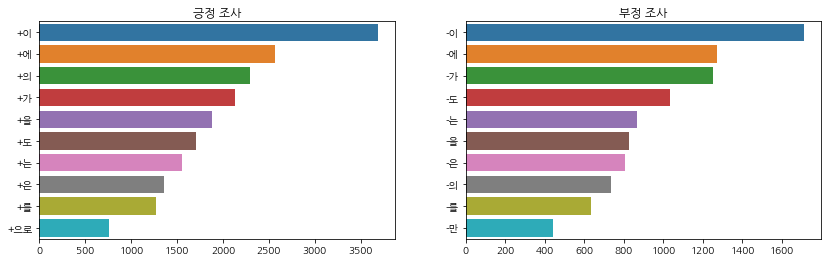

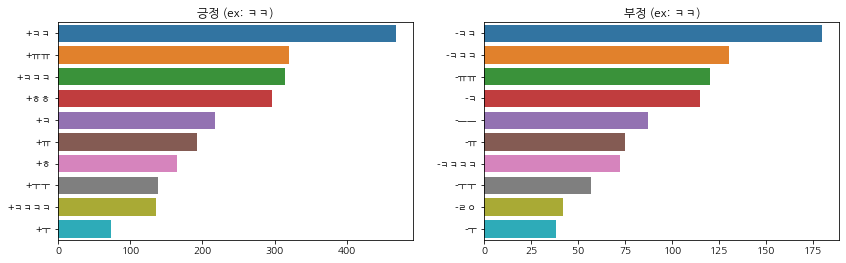

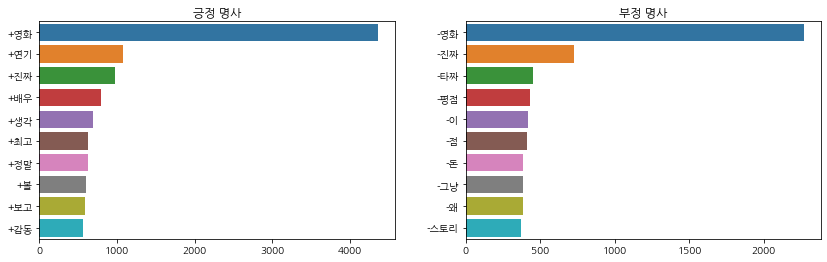

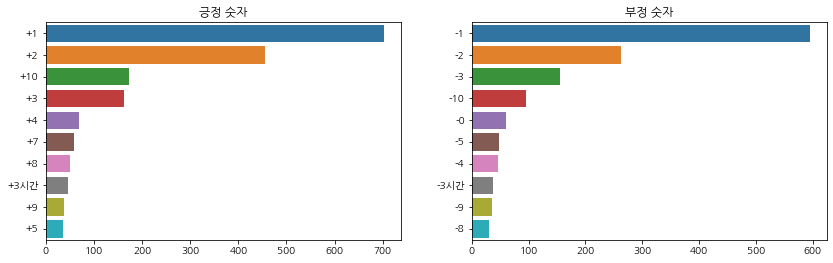

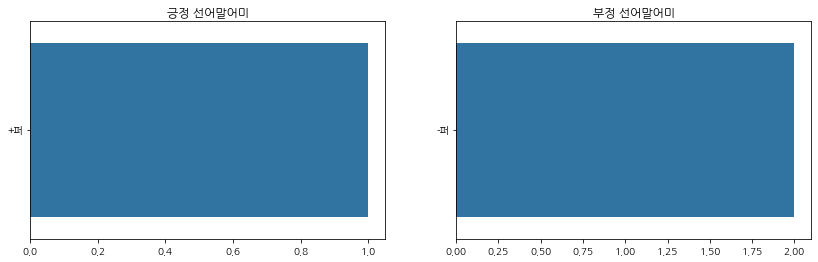

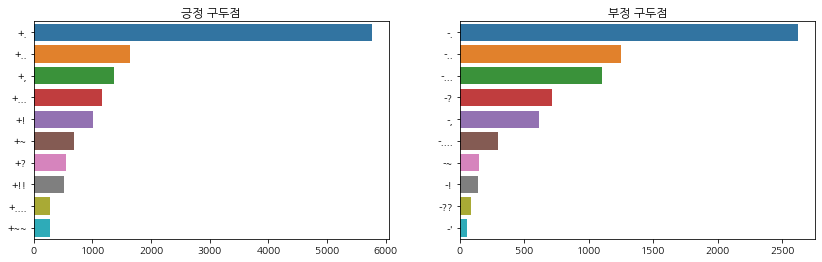

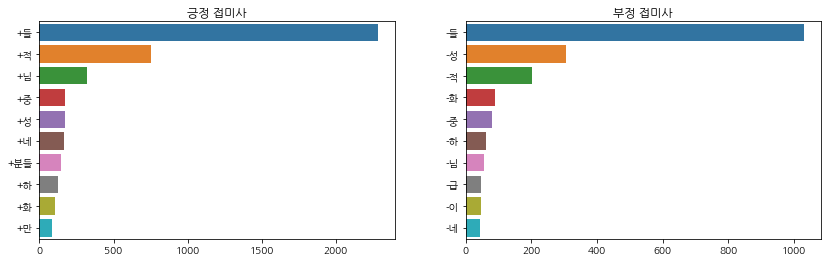

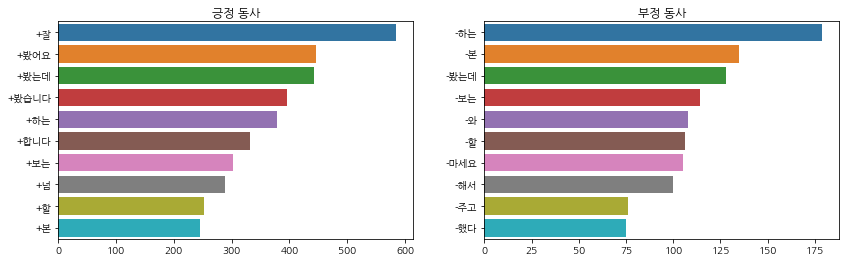

"\n눈에 띄는 결과로는\n형용사에서 재밌게 좋았어요 좋은 이런 긍정적인 단어가 많이 나옴을 볼 수 있고, 부정은 아까운 없고 솔직히 같은 단어들이 나옴을 볼 수 있다.\n부사에서는 그나마, 걍 등이 부정에 나옴을 볼 수 있고\n조사나 접속사에도 '하지만', '도' 이런것으로 갈릴 줄 알았는데 비슷한 분포를 보이고\n채팅어에서 눈여겨 볼건 'ㅋㅋ'등은 두 부분에 등장했지만 'ㅎㅎ'은 긍정데이터에서 많이 나타남을 볼 수 있다.\n이외에도 구두점에 긍정데이터에는 !가 많이 쓰인점, 동사에도 긍정에는 잘, 부정에는 마세요 가 나타난다.\n구분이 되지않는 품사들도 있지만 생각보다 리뷰데이터들이 품사별로 구분되는 특징들을 가지고 있음을 볼 수 있다.\n\n이렇게 형태소 분석을 하여 딥러닝 모델을 만들면 긍정데이터 부정데이터를 분류하는 중요한 피쳐가 될거라고 생각이 된다.\n이번에 모델링까지는 하지 않겠다...ㅠㅠ  시간부족쓰\n"

In [10]:
for pos, korPos in okt.tagset.items():
    # 품사당 빈도수가 가장 높은 10개만 그래표에 나타내 보겠다
    _pos = posVoca[pos].most_common()[:10]
    _neg = negVoca[pos].most_common()[:10]

    # 해당하는 품사에 데이터가 없다면 패스!
    if len(_pos) == 0 or len(_neg) == 0:
        continue
    
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    # 품사별 토큰의 카운트를 가로그래프로 표시하기 
    sns.barplot([_[1] for _ in _pos], ["+" + _[0] for _ in _pos], ax=ax1)
    sns.barplot([_[1] for _ in _neg], ["-" + _[0] for _ in _neg], ax=ax2)

    ax1.title.set_text('긍정 ' + korPos)
    ax2.title.set_text('부정 ' + korPos)

    plt.show()
'''
눈에 띄는 결과로는
형용사에서 재밌게 좋았어요 좋은 이런 긍정적인 단어가 많이 나옴을 볼 수 있고, 부정은 아까운 없고 솔직히 같은 단어들이 나옴을 볼 수 있다.
부사에서는 그나마, 걍 등이 부정에 나옴을 볼 수 있고
조사나 접속사에도 '하지만', '도' 이런것으로 갈릴 줄 알았는데 비슷한 분포를 보이고
채팅어에서 눈여겨 볼건 'ㅋㅋ'등은 두 부분에 등장했지만 'ㅎㅎ'은 긍정데이터에서 많이 나타남을 볼 수 있다.
이외에도 구두점에 긍정데이터에는 !가 많이 쓰인점, 동사에도 긍정에는 잘, 부정에는 마세요 가 나타난다.
구분이 되지않는 품사들도 있지만 생각보다 리뷰데이터들이 품사별로 구분되는 특징들을 가지고 있음을 볼 수 있다.

이렇게 형태소 분석을 하여 딥러닝 모델을 만들면 긍정데이터 부정데이터를 분류하는 중요한 피쳐가 될거라고 생각이 된다.
이번에 모델링까지는 하지 않겠다...ㅠㅠ  시간부족쓰
'''

# 2. 최근 인기많은 영화  N개 과연 클러스터링을하면 N개로 군집화가 잘 될지

In [11]:
data['title'].value_counts()[:10]
# 최근에 스크린 독점이 없어 영화가 다양한 분포를 보임을 알수 있다.
# top3 는 타짜:원 아이드 잭, 나쁜녀석들: 더 무비, 유열의 음악앨범이다 3개의 주제로 클러스터링 하면 잘 될까요?
# 일단 전체 데이터로 클러스터링을 진행해 보겠다.

타짜: 원 아이드 잭             3263
나쁜 녀석들: 더 무비            2121
유열의 음악앨범                1404
그것: 두 번째 이야기            1357
엑시트                     1025
봉오동 전투                   940
힘을 내요, 미스터 리             830
변신                       782
사자                       311
극장판 헬로카봇 : 달나라를 구해줘!     310
Name: title, dtype: int64

# 전처리
### 군집화를 확인하기위해 리뷰의 가장 특징이 잘 드러나는 것은 명사기 때문에 명사만 저장하도록 전처리하겠다.
### 불용어 부분은 명사만 선택하면서 저절로 짤릴 것이다.
### 또, 1글자는 거르도록하겠다. 의미를 담고있을 일이 적기 때문이다.

In [12]:
# data['review']부분을 명사부분만 골라 저장
sentences  = [[token[0] for token in okt.pos(review) if token[1] == 'Noun' and len(token[0]) > 1] for review in data['review_content']]

In [13]:
sentences[:3]

[['미국', '원폭', '독립', '독립운동', '학살'],
 ['우리', '후손', '원전', '세상', '더미'],
 ['인간', '본능', '현실', '미국', '청소년', '왕따', '소녀', '통해', '영화']]

In [14]:
from gensim.models import Word2Vec, FastText

# 64차원으로 임베딩
cbow = Word2Vec(sentences, min_count=1, size=64)
# fasttext = FastText(sentences, min_count=1, size=64)

# cbow를 선택한것은 리뷰는 집약적으로 표현한 데이터이므로
# 전체적인 통계정보나 subword의 의미를 파악하기보다는 각 단어의 유사도를 판단하는 것이 중요하다고 생각했습니다.

C:\Users\USER\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [15]:
print(cbow.wv['독립']) # 워드 임베딩 된 형태

[-5.3017199e-01 -3.8445467e-01 -6.2125117e-01  7.7453122e-02
  2.8719094e-02  1.3010593e-01  6.2818289e-01 -1.1704362e-01
 -9.6523300e-02  3.3494699e-01 -3.6773431e-01 -2.3385337e-01
  7.1423125e-01 -1.3460360e-01  2.4572425e-01  1.5777870e-01
 -2.6499805e-01 -9.0034284e-02  1.9337776e-01  6.9412208e-01
  5.4352745e-02 -1.3026488e-01 -3.3012339e-01  6.4785880e-01
 -5.0619632e-01 -4.0272412e-01  2.7335563e-01  8.3648580e-01
  5.3774947e-01 -9.8873806e-01  2.0825160e-03 -6.8268344e-02
  4.5740053e-01 -2.1133086e-01 -3.7235799e-01  5.9535199e-01
  4.4124928e-01 -2.1414171e-01  5.9836023e-02 -8.9328647e-02
 -2.7884516e-01 -2.1620584e-01  1.4728878e-01 -1.1063382e-01
  1.7440693e-01 -1.2839402e-01 -6.4881690e-02  1.5497905e-01
  6.1197203e-01  6.0024321e-01  2.1519214e-02  2.6686299e-01
 -4.6582337e-04 -2.4449606e-01 -4.6366629e-01 -9.8380095e-01
 -2.9449132e-01  1.7859231e-01  6.8899846e-01  3.5252580e-01
 -2.3813112e-01 -4.9690470e-01 -5.2008968e-02 -6.2410825e-01]


In [16]:
print(cbow.wv.most_similar('독립'))# '우리', '독립군' 등이 나온거보면 임베딩 결과가 생각보다 괜찮은 것 같다.)

[('대한민국', 0.9993587136268616), ('존경', 0.9993377923965454), ('지금', 0.9992952346801758), ('우리', 0.999289870262146), ('독립군', 0.9992791414260864), ('은희', 0.9992653131484985), ('나라', 0.9992647171020508), ('대한', 0.9992523193359375), ('항상', 0.9992456436157227), ('일본', 0.9992433190345764)]


In [17]:
print (len(cbow.wv.vocab)) # 단어의 개수는 8524개이다.

11485


In [18]:
X = cbow[cbow.wv.vocab]
# 클러스터링하기위해 X에다 데이터 넣기
# 임베딩된 벡터들이 들어가게 된다

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [19]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
import numpy as np

# 단어벡터들을 n개의 클러스터로 군집화 해주는 함수 kmeans++을 사용하였다.
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++')
    idx = kmeans_clustering.fit_predict(word_vectors)
    
    return kmeans_clustering.cluster_centers_, idx

# 출처 : https://medium.com/ml2vec/using-word2vec-to-analyze-reddit-comments-28945d8cee57
# 대부분 그대로 사용하였고, 파리미터의 수를 조정하여 사용하였다.

In [20]:
centers, clusters = clustering_on_wordvecs(X, 3)
centroid_map = dict(zip(cbow.wv.index2word, clusters))

In [21]:
pd.Series(clusters).value_counts() # 압도적으로 1개 주제가 제일 많음을 볼 수 있다. 영화라는 공통분모가 있어서 그런 것같다  제대로 클러스터링 됐는지 볼까요?

1    10348
0      880
2      257
dtype: int64

In [22]:
# 각 클러스터에 중심점에서 가장 유사한 벡터들(단어들) k개를 뽑는 함수
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df

In [23]:
top_words = get_top_words(cbow.wv.index2word, 50, centers, X)

In [24]:
top_words.head()

,Cluster #0,Cluster #1,Cluster #2
1,부탁,원제,루즈
2,명품,라그,대구
3,영화인,죽죽,등장
4,대가리,동크,계속
5,국산,화산고,한번


In [25]:
# 군지화된 단어들을 워드클라우드로 그려서 보여주는 함수
def display_cloud(cluster_num, cmap):
    wc = WordCloud(
        font_path = "c:/Windows/Fonts/NanumGothic.ttf",
        width = 2000,
        height = 1500,
        background_color="black",
        max_words=20,
        colormap=cmap)
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num-1).zfill(1)]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('이전cluster_' + str(cluster_num), bbox_inches='tight')

In [ ]:
from itertools import cycle
from wordcloud import WordCloud, ImageColorGenerator
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

centers, clusters = clustering_on_wordvecs(X, 3);
centroid_map = dict(zip(cbow.wv.index2word, clusters));
top_words = get_top_words(cbow.wv.index2word, 50, centers, X)
for i in range(3):
    col = next(cmaps);
    display_cloud(i+1, col)
    
'''
음......................... 딱히 군집화된 특징을 찾지 못하겠다!

'''

![title](이전cluster_1.png) ![title](이전cluster_2.png) ![title](이전cluster_3.png)

# 결과가 별로 좋지 않은 것 같다.
## 그러면 타짜: 원 아이드 잭,나쁜 녀석들: 더 무비, 유열의 음악앨범 데이터만 가지고 군집화를 수행해보자

In [30]:
data3 = data[data['title'].isin(['타짜: 원 아이드 잭', '나쁜 녀석들: 더 무비', '유열의 음악앨범'])]

In [31]:
len(data3) # 6788 줄었다.

6788

In [32]:
def display_cloud(cluster_num, cmap):
    wc = WordCloud(
        font_path = "c:/Windows/Fonts/NanumGothic.ttf",
        width = 2000,
        height = 1500,
        background_color="black",
        max_words=20,
        colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num-1).zfill(1)]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('이후cluster_' + str(cluster_num), bbox_inches='tight')

### 전처리

In [33]:
sentences3  = [[token[0] for token in okt.pos(review) if token[1] == 'Noun' and len(token[0]) > 1] for review in data3['review_content']]
cbow3 = Word2Vec(sentences3, min_count=1, size=64)
print (len(cbow3.wv.vocab)) # 단어의 개수는 3639개이다.
X = cbow3[cbow3.wv.vocab]

4601


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [35]:
cbow3.wv.most_similar('타짜') # 추석에 보고 사람 정말 감독 원작 등이 눈에 띈다

[('사람', 0.999894380569458),
 ('정말', 0.9998940229415894),
 ('감독', 0.9998921751976013),
 ('영화', 0.9998896718025208),
 ('추석', 0.9998821020126343),
 ('한국영', 0.9998809099197388),
 ('정도', 0.999874472618103),
 ('장기', 0.9998728036880493),
 ('원작', 0.9998723864555359),
 ('때문', 0.9998700618743896)]

### 군집화

In [ ]:
centers, clusters = clustering_on_wordvecs(X, 3);
centroid_map = dict(zip(cbow.wv.index2word, clusters));
top_words = get_top_words(cbow.wv.index2word, 50, centers, X)
for i in range(3):
    col = next(cmaps);
    display_cloud(i+1, col)
    
'''
3 영화를 전부 안봐서 모르겠지만,

첫번째 군집은 어거지와 과대 왜봄 등의 단어가 나오는 것으러 보아 매우 부정적인 단어들이 묶인것으로 보인다.
제니퍼 뉴욕 나온 영화가 그런 것 같다.


두번째 군집은 남자 스토리 타짜 반전 여부우등의 단어가 나온걸로 보아 타짜 영화고
여배우의 반전모습이나 한몫을 하는 등을 예상할 수 있고 원작과의 비교를 많이 한 것 같다.

세번째 군집은 어린시절 단체 고민....... 뭔지 잘 모르겠다.... 역시 비지도학습은 어려운 것 같다.
아마 kmeans로 단순 거리만으로 했기때문에 이런결과가 나온것 같기도 하다!
'''

![title](이후cluster_1.png) ![title](이후cluster_2.png) ![title](이후cluster_3.png)